In [5]:
# !pip install fasttext -U
# !pip install contractions -U
# !pip install pyspellchecker -U
# !pip install matplotlib -U
# !pip install seaborn -U
# !pip install nltk -U
# !pip install wordcloud -U
# !pip install scikit-learn -U
# !pip install scipy -U
# !pip install certifi


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [18]:
# !wget -P resources/ 'https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin'
# !gdown "0Bz8a_Dbh9QhbZVhsUnRWRDhETzA" -O "resources/dataset.zip"

zsh:1: command not found: wget


## Imports

In [105]:
import pandas as pd
import fasttext
from typing import List, Callable, Tuple
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import string
import os
import concurrent.futures
import contractions
from nltk.tokenize import word_tokenize
from sklearn.utils.extmath import randomized_svd
from spellchecker import SpellChecker
import nltk
from wordcloud import WordCloud
import re
import numpy as np
from numpy import diag
from scipy.sparse.linalg import svds
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gardini/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/gardini/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gardini/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Constants

In [6]:
RESOURCES_FOLDER = 'resources'
FAST_TEXT_MODEL = f'{RESOURCES_FOLDER}/lid.176.bin'
TRAIN_PATH = f'{RESOURCES_FOLDER}/train.csv'
NEGATIVE_STOPWORDS = {
    'not',
    'no',
    'none',
    'neither',
    'nor',
    'never',
    'nowhere',
    'nothing',
    'nobody',
    'hardly',
    'scarcely',
    'barely',
    'doesn\'t',
    'isn\'t',
    'wasn\'t',
    'hasn\'t',
    'can\'t',
    'couldn\'t',
    'won\'t',
    'wouldn\'t',
    'don\'t',
    'didn\'t',
    'aren\'t',
    'aren\'t',
    'weren\'t',
    'hasn\'t',
    'shouldn\'t',
    'mustn\'t',
    'mightn\'t',
    'shan\'t',
    'needn\'t'
}

## Utility functions

- `sample balanced`: takes at most `max_samples_per_class` from each class specified in `groupby_column`
- `compute_languages`: compute language for specified Series. It creates a new Series with `__label__[language]` for each text in the original Series

### DataFrame processing

In [7]:
def sample_balanced(dataframe: pd.DataFrame, 
                    max_samples_per_class: int = 20_000, 
                    groupby_column: str = 'stars', 
                    random_state: int = 1234):
  return dataframe.groupby(groupby_column)\
  .apply(lambda x: x.sample(max_samples_per_class, random_state=random_state))\
  .reset_index(drop=True)

def compute_languages(texts: pd.Series):
  model = fasttext.load_model(FAST_TEXT_MODEL)
  return texts.apply(lambda x:model.predict(x)[0][0])

def set_columns(columns: List[str]):
  def _set_columns(dataframe: pd.DataFrame):
    dataframe.columns = columns
    return dataframe
  return _set_columns

def drop_na():
  def _drop_na(dataframe: pd.DataFrame):
    return dataframe.dropna()
  return _drop_na

def remove_not_modal_languages(extracted_languages: pd.Series):
  def _remove_languages(dataframe: pd.DataFrame):
    modal_language = extracted_languages.value_counts().index[0]
    return dataframe[extracted_languages == modal_language].reset_index(drop=True)
  return _remove_languages

def compute_and_remove_not_modal_languages(text_column: str = 'text'):
  def _compute_and_remove(dataframe: pd.DataFrame):
    computed_languages = compute_languages(dataframe[text_column])
    return remove_not_modal_languages(computed_languages)(dataframe)
  return _compute_and_remove

def apply_preprocess(preprocess_functions: List[Callable]):
  def _apply_preprocess(dataframe: pd.DataFrame):
    for function in preprocess_functions:
      dataframe = function(dataframe)
    return dataframe
  return _apply_preprocess

### Text processing

In [71]:
def to_lower(text: str):
  return text.lower()

def expand_contraction(word: str):
  return contractions.fix(word)

def is_stopword(language: str = 'english'):
  stopwords_set = set(stopwords.words(language)) - NEGATIVE_STOPWORDS
  def _is_stopword(word: str):
    return word in stopwords_set
  return _is_stopword

def cleared_stopwords(language: str = 'english'):
    return set(stopwords.words(language)) - NEGATIVE_STOPWORDS

def is_punctuation(word: str):
  return word in string.punctuation

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def correct_word(language: str = 'eng'):
  checker = SpellChecker(language)
  def _correct_words(word: str):
    return checker.correction(word)
  return _correct_words

def tokenize(text: str):
  return word_tokenize(text)

def split(text: str):
    return text.split()

def preprocess_text(text: str):
    # correct_word_fn = np.vectorize(correct_word('en'))
    expand_contraction_fn = np.vectorize(expand_contraction)
    lower = text.lower()
    no_numbers = re.sub(r'\d+', '', lower)
    split_text = np.array(split(no_numbers), dtype=object)
    # corrected_words = correct_word_fn(split_text)
    # expanded_contraction = expand_contraction_fn(corrected_words[corrected_words != None])
    expanded_contraction = expand_contraction_fn(split_text)
    no_punctuation = re.sub(r'[^a-z]', ' ', ' '.join(expanded_contraction)).strip()
    no_stopwords_pattern = r'\b(?:' + '|'.join(map(re.escape, cleared_stopwords('english'))) + r')\b'
    no_stopwords = re.sub(no_stopwords_pattern, ' ', no_punctuation)
    no_more_spaces = re.sub(r'\s+', ' ', no_stopwords).strip()
    return no_more_spaces

def apply_concurrent(function: Callable[[str], str], workers:int = os.cpu_count(), ):
  def _preprocess_series(series: pd.Series):
    with concurrent.futures.ThreadPoolExecutor(workers) as executor:
        return list(executor.map(function, series.values))
  return _preprocess_series
  

## LSA Manipulation

In [108]:
def tf_idf(corpus: pd.Series) -> Tuple[np.matrix, np.array]:
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
    # l2 norm is already applied by TfidfVectorizer
    return tfidf_matrix, tfidf_vectorizer.get_feature_names_out()

def normalize(values: np.array):
    l2_norm = np.linalg.norm(values, ord=2)
    return values / l2_norm


def sparsity(sparse_matrix: csr_matrix):
    print(sparse_matrix.shape)
    total_elements = sparse_matrix.shape[0] * sparse_matrix.shape[1]
    zero_elements = total_elements - sparse_matrix.count_nonzero()
    return zero_elements / total_elements    

### Visualization

In [75]:
def plot_distribution(distribution: pd.Series, 
                      xlabel:str = '', 
                      ylabel:str = '', 
                      title: str = '', 
                      invert_axis: bool = False):
  plt.figure(figsize=(8, 4))  # Optional: Adjust the figure size
  data = distribution.to_list() if not invert_axis else list(distribution.index)
  index = list(distribution.index) if not invert_axis else distribution.to_list()
  sns.barplot(x=data, y=index)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()
  
def plot_singular_values(singular_values: List[float]):
    plt.figure(figsize=(8, 6))
    sns.lineplot(x=np.arange(1, len(singular_values) + 1), y=singular_values, marker='o')
    #plt.yscale('log')  # Use a logarithmic scale for the y-axis (optional)
    plt.title('Singular Values')    
    plt.show()

def word_cloud(text: str, title: str = ""):
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title(title)
  plt.axis('off')  # Hide the axis
  plt.show()

## Load the data

Dataset is a csv divided in 3 columns:
- *stars*: is the number of stars given by users in the review
- *title*: is the title of the review
- *text*: is the text of the review

Loading of dataframe, the original csv doesn't have column names, so I add it.

In [11]:
train = pd.read_csv(TRAIN_PATH, header=None)
train = set_columns(['stars', 'title', 'text'])(train)
train

,stars,title,text
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...
...,...,...,...
2999995,1,Don't do it!!,The high chair looks great when it first comes...
2999996,2,"Looks nice, low functionality",I have used this highchair for 2 kids now and ...
2999997,2,"compact, but hard to clean","We have a small house, and really wanted two o..."
2999998,3,Hard to clean!,I agree with everyone else who says this chair...


Show the number of elements for each class

In [12]:
train['stars'].value_counts()

5    600000
4    600000
3    600000
2    600000
1    600000
Name: stars, dtype: int64

As we can see classes are balanced. Now check the number of NaNs

In [13]:
train.isna().sum()

stars     0
title    76
text      0
dtype: int64

Remove empty cells

In [14]:
train = drop_na()(train)
train.isna().sum()

stars    0
title    0
text     0
dtype: int64

Since the dataframe is very large operations on text could be very slow. Let's select only 30_000 instances for each class

In [15]:
train = sample_balanced(train, max_samples_per_class=15_000, groupby_column='stars')
train['stars'].value_counts()

5    15000
4    15000
3    15000
2    15000
1    15000
Name: stars, dtype: int64

Author specifies that there are some reviews not in English. Let's use fasttext, developed by Facebook, to find the languages.

In [16]:
languages_text = compute_languages(train['text'])

Now check the distributions of languages

In [17]:
languages_text.value_counts()

__label__en    74782
__label__es      156
__label__ja       35
__label__fr       12
__label__pt        6
__label__it        4
__label__de        3
__label__da        1
__label__af        1
Name: text, dtype: int64

There are instances not in English. Make same inspection for title

In [18]:
languages_title = compute_languages(train['title'])
languages_title.value_counts()

__label__en     70575
__label__ja       807
__label__fr       609
__label__es       547
__label__de       497
                ...  
__label__io         1
__label__sco        1
__label__pnb        1
__label__lv         1
__label__mt         1
Name: title, Length: 85, dtype: int64

Remove all not English reviews in title and text

In [19]:
train = remove_not_modal_languages(languages_text)(train)
train = remove_not_modal_languages(languages_title)(train)

Now we use only 25_000 for each class, 125_000 reviews in total

In [20]:
train = sample_balanced(train, max_samples_per_class=5_000, groupby_column='stars')
train['stars'].value_counts()

5    5000
4    5000
3    5000
2    5000
1    5000
Name: stars, dtype: int64

## Text preprocessing

First of all merge title with text. That add more information (title could be a summarized version of the text)

In [21]:
train['text'] = train['title'] + " " + train['text']
del train['title']
train

,stars,text
0,1,handle comes loose I am pleased with the cooki...
1,1,Which Restaurant ? I have tried & or studied t...
2,1,Wish I had thought twice before buying this I ...
3,1,Slime! I read one of these books years ago and...
4,1,Extremely Disappointed!! I just received the S...
...,...,...
24995,5,A must for all programmers Whether or not inte...
24996,5,Inspires clarity of purpose and vision After r...
24997,5,Perfect. The best Discworld novel I've read to...
24998,5,BEST CONCERT VIDEO I HAVE EVER SEEN A WONDERFU...


Now we preprocessed the dataframe to be manipulated and used in deep learning methods and with LSA. The operations that are performed sequentially are:
- text to lower case
- tokenization, 
- expansion of contractions, 
- word correction, 
- stop word removal 
- punctuation removal

In [22]:
train['text'] = apply_concurrent(preprocess_text)(train['text'])

In [23]:
# grouped = train.groupby('stars')['text'].apply(lambda x: ' '.join(x)).reset_index()
# for star_rating, reviews in zip(grouped['stars'], grouped['text']):
#   word_cloud(reviews, f'Word cloud for {star_rating} stars')
  
# Concatenate the aggregated reviews into a single string

In [110]:
tfidf_sparse, words = tf_idf(train['text'])
print(f'{len(words)} in founded')
U, Sigma, V_T = randomized_svd(tfidf_sparse, n_components=100)


print(f'V transposed {V_T.shape}')
print(V_T)

53167 in founded
V transposed (100, 53167)
[[ 1.81799025e-03  8.96225929e-04  5.98477499e-05 ...  1.33831263e-04
   1.65544821e-04  6.23839486e-05]
 [-9.50524940e-04 -9.90301206e-04  4.15309213e-05 ... -1.40881440e-04
   6.50342876e-04 -1.16294139e-04]
 [-1.92005440e-03 -1.55078077e-03 -3.48000626e-05 ...  7.59610717e-05
   2.20582492e-04  4.32697902e-07]
 ...
 [-4.13482750e-03 -2.11270353e-03 -8.08091011e-05 ...  4.18766646e-04
   2.62925724e-04  9.50549247e-04]
 [ 2.54282032e-03  5.55373199e-04 -1.95087503e-04 ... -7.59899075e-05
  -2.35447014e-03  9.63647388e-05]
 [-1.34424888e-03  1.34822836e-03 -7.17633200e-05 ... -1.36282789e-04
  -1.53175949e-03  6.37765614e-04]]


In [79]:
print(f'U shape: {U.shape}')
print(U)

U shape: (25000, 100)
[[ 0.00263958 -0.00218926 -0.00224323 ... -0.00147227  0.00292387
   0.0005779 ]
 [ 0.00626319  0.00348412 -0.0011479  ...  0.01479196 -0.00057604
  -0.00851435]
 [ 0.00566831 -0.00403804 -0.00359753 ...  0.00015696 -0.00475882
   0.00177262]
 ...
 [ 0.00793639  0.0105103   0.00122689 ... -0.00094017 -0.01186797
   0.0025232 ]
 [ 0.00363784 -0.00249429  0.00178558 ...  0.01364277 -0.01674047
   0.01189056]
 [ 0.00339482  0.00650376 -0.00072918 ...  0.00469984  0.00040179
  -0.00185968]]


In [80]:
print(f'Sigma {Sigma.shape}')
print(Sigma)

Sigma (100,)
[20.52709903 11.71596801  9.66240955  9.34304845  8.33592456  7.9170591
  7.27720855  7.19437573  6.86788544  6.76373627  6.70265509  6.44049326
  6.28077924  6.13482304  6.03894347  5.97834135  5.93991384  5.86466984
  5.81958774  5.74959127  5.67022496  5.62018596  5.57623645  5.5279978
  5.49376532  5.46849277  5.45511915  5.39746387  5.3488461   5.30906662
  5.22897246  5.21119045  5.18797851  5.16384191  5.12333802  5.10109492
  5.05015784  5.00793727  4.98264148  4.97375561  4.95975113  4.92991865
  4.91066504  4.90589879  4.85141581  4.82802045  4.80966478  4.79160347
  4.77929149  4.76111406  4.75223593  4.73800007  4.70781093  4.68719907
  4.66594713  4.66321257  4.63098948  4.62636124  4.59596024  4.58197768
  4.57798645  4.55842152  4.54299988  4.53612751  4.51970875  4.51057726
  4.50258028  4.48442533  4.47473765  4.45582     4.45166262  4.44830625
  4.42981972  4.41779752  4.39346757  4.39075732  4.3735196   4.3639489
  4.35582987  4.3308752   4.32721717  4.3

In [81]:
print(f'V transposed {V_T.shape}')
print(V_T)

V transposed (100, 53167)
[[ 1.81799025e-03  8.96225929e-04  5.98477499e-05 ...  1.33831263e-04
   1.65544821e-04  6.23839486e-05]
 [-9.50524940e-04 -9.90301206e-04  4.15309213e-05 ... -1.40881440e-04
   6.50342876e-04 -1.16294139e-04]
 [-1.92005440e-03 -1.55078077e-03 -3.48000626e-05 ...  7.59610717e-05
   2.20582492e-04  4.32697902e-07]
 ...
 [-4.13482750e-03 -2.11270353e-03 -8.08091011e-05 ...  4.18766646e-04
   2.62925724e-04  9.50549247e-04]
 [ 2.54282032e-03  5.55373199e-04 -1.95087503e-04 ... -7.59899075e-05
  -2.35447014e-03  9.63647388e-05]
 [-1.34424888e-03  1.34822836e-03 -7.17633200e-05 ... -1.36282789e-04
  -1.53175949e-03  6.37765614e-04]]


[20.52709903 11.71596801  9.66240955  9.34304845  8.33592456  7.9170591
  7.27720855  7.19437573  6.86788544  6.76373627]


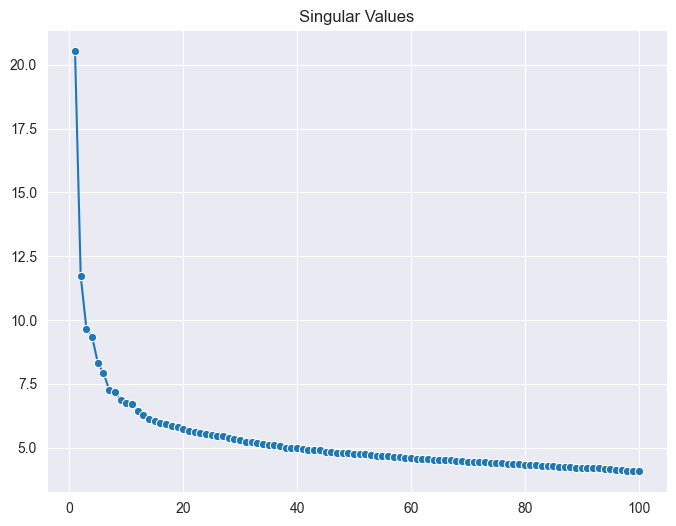

In [76]:
print(Sigma[:10])
plot_singular_values(Sigma)

In [117]:
terms_lsa = normalize(U @ diag(Sigma))
documents_lsa = normalize(diag(Sigma) @ V_T)

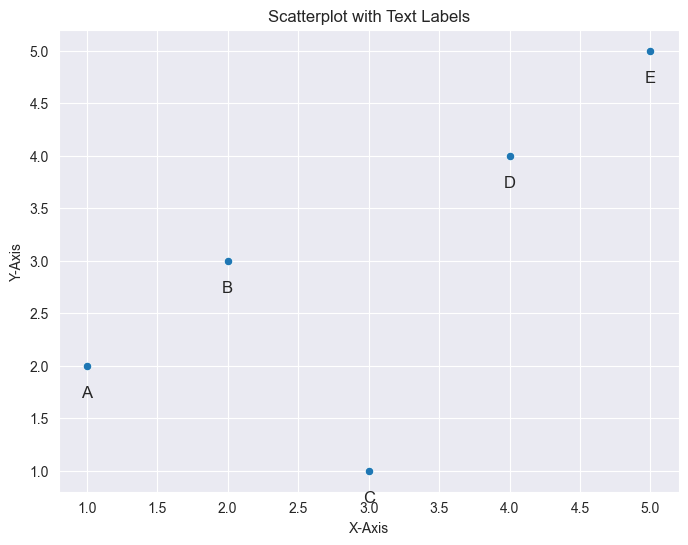

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a sample DataFrame (replace with your own data)
data = pd.DataFrame({
    'X': [1, 2, 3, 4, 5],
    'Y': [2, 3, 1, 4, 5],
    'Label': ['A', 'B', 'C', 'D', 'E']
})

# Create a Seaborn scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=terms_lsa, x='X', y='Y')

# Add text labels under each point
for row in data.itertuples():
    plt.text(row.X, row.Y - 0.3, row.Label, ha='center', fontsize=12)

# Add labels, title, and adjust plot settings as needed
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
plt.title('Scatterplot with Text Labels')
plt.grid(True)

# Show the plot
plt.show()




In [104]:
U.shape

(25000, 100)

In [34]:

dtm_sparse = dtm(train['text'])
total_elements = dtm_sparse.shape[0] * dtm_sparse.shape[1]

# Calculate the sparsity
sparsity = 1 - (dtm_sparse.count_nonzero() / total_elements)
print(f'Matrix is sparse at {sparsity * 100:.2f} %')
type(dtm_sparse)

Matrix is sparse at 85.13 %


scipy.sparse.csr.csr_matrix

Matrix is sparse at 99.93 %


In [27]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(train['text'])
vectorizer = CountVectorizer()
dtm_matrix = vectorizer.fit_transform(train['text'])

# Convert tfidf_matrix to a sparse CSR (Compressed Sparse Row) matrix
tfidf_sparse = csr_matrix(tfidf_matrix)
dtm_sparse = csr_matrix(dtm_matrix)

k = 2  # Number of singular values to compute
U, Sigma, VT = svds(tfidf_sparse, k=k)
dtm_sparse.count_nonzero()/(dtm_sparse.shape[0]*dtm_sparse.shape[1]) * 100

0.06650871080139373

## Create Tokenizer